# WingsNet

In [1]:
#General OS and numerical
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import argparse
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange as trange
import itertools
from PIL import Image
from collections import OrderedDict
import re

#Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

#Data management
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

#Image processing
import cv2 as cv
from torchvision import transforms

## Args/Params

In [4]:
#GPUs
print("CUDA availability = {}, number devices = {}".format(torch.cuda.is_available(), torch.cuda.device_count()))
for x in range(torch.cuda.device_count()):
    print(x, torch.cuda.get_device_name(x))
    
#Flags
TRAIN = True

#Data
# DATA_PATH = "/storage/data/wingNet/landmarks"
# DATA_PATH = "/storage/data/wingNet/teresa_data"
DATA_PATH = "/storage/data/wingNet/shawn_data"
NUM_LAYERS = 16
TRAIN_RATIO = 0.95
RESIZE = (256, 256)

#Training
gpu_name = "cuda:2"
# DEVICE = torch.device("cpu") 
DEVICE = torch.device(gpu_name if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 24
N_ITERS = 4

z_scale = 843
c_scale = 828

IMG_SIZE = (2048, 1536)

CUDA availability = True, number devices = 9
0 GeForce GTX 1080 Ti
1 GeForce GTX 1080 Ti
2 GeForce GTX 1080 Ti
3 GeForce GTX 1080 Ti
4 GeForce GTX 1080 Ti
5 GeForce GTX 1080 Ti
6 GeForce GTX 1080 Ti
7 GeForce GTX 1080 Ti
8 GeForce GTX 1080


## Dataloader

In [8]:
class WingData(Dataset):
    def __init__(self, list_paths, labels, resize_dims=(512, 512), device='cpu'):
        'Initialization'
        super().__init__()
        
        self.list_paths = list_paths
        self.labels = labels
        self.device = device
        self.resize_dims = resize_dims
        
        self.data_transform = transforms.Compose([
            transforms.Resize(resize_dims), 
            transforms.ToTensor()])
        
        self.seq = iaa.Sequential([#iaa.Affine(translate_percent=(10, 10), rotate=(-45, 45), 
#                                               scale=(0.8, 1.2), mode='edge'), #'reflect'
#                                    iaa.Crop(px=(0, 50)), # crop images from each side by 0 to 16px (randomly chosen)
#                                    iaa.Fliplr(0.5), # horizontally flip 50% of the images
#                                    iaa.Flipud(0.5),
#                                    iaa.AddToHueAndSaturation((-50, 50)),
#                                    iaa.AdditiveGaussianNoise(0, 0.1),
                                   iaa.Resize(resize_dims)])


    def np_to_keypoints(self, np_kpoints):
        kps = [
            Keypoint(x=np_kpoints[0], y=IMG_SIZE[1]-np_kpoints[1]),
            Keypoint(x=np_kpoints[2], y=IMG_SIZE[1]-np_kpoints[3]),
            Keypoint(x=np_kpoints[4], y=IMG_SIZE[1]-np_kpoints[5]),
            Keypoint(x=np_kpoints[6], y=IMG_SIZE[1]-np_kpoints[7]),
            Keypoint(x=np_kpoints[8], y=IMG_SIZE[1]-np_kpoints[9]),
            Keypoint(x=np_kpoints[10], y=IMG_SIZE[1]-np_kpoints[11]),
            Keypoint(x=np_kpoints[12], y=IMG_SIZE[1]-np_kpoints[13]),
            Keypoint(x=np_kpoints[14], y=IMG_SIZE[1]-np_kpoints[15]),
        ]
        return kps
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_paths)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        sample_path = self.list_paths[index]

        if not os.path.isfile(sample_path):
            print("{} is not a file/does not exist!".format(sample_path))
        # Load data and get label
#         img = Image.open(sample_path)
        image = cv.imread(sample_path)
        image = cv.normalize(image, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    
        kps = self.np_to_keypoints(self.labels[index].flatten())
        kpsoi = KeypointsOnImage(kps, shape=image.shape)   
        image_aug, kpsoi_aug = self.seq(image=image, keypoints=kpsoi)
#         image_aug = image
#         kpsoi_aug = kpsoi
    
    
        input_tensor = torch.tensor(image_aug).transpose(1,2).transpose(0,1)
        output_tensor = torch.tensor(kpsoi_aug.to_xy_array().flatten())
        
        return input_tensor, output_tensor, sample_path

In [9]:
# DATA_PATH = "/storage/data/wingNet/landmarks"
data_files = pd.read_csv(DATA_PATH, header=None).values.flatten().tolist()

image_paths = []
feature_coords = []

for file in data_files:
#     print(file)
    f = open(file,'r')
    cnt = 0
    
    folder_path = os.path.dirname(file)
    img_feature_coords = []
    for line in f:  
        if cnt > 0 and cnt <=8:
            coords_str = str.split(line)
#             print(coords_str)
            img_feature_coords.append(coords_str)
        elif cnt == 9:
            image_name = re.split('=|\n', line)
            image_path = folder_path+"/"+image_name[1]
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                feature_coords.append(np.asarray(img_feature_coords, dtype=np.float32, order='C'))
#             print(image_path)
            img_feature_coords = []
            cnt = -2
        cnt += 1

data = WingData(image_paths, feature_coords, device=DEVICE)
train_size = int(len(data)*TRAIN_RATIO)
data_train, data_test = random_split(data, [train_size, len(data)-train_size])
dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
print("Using {} images in training, {} in validation.".format(len(data_train), len(data_test)))

Using 911 images in training, 48 in validation.


======== /storage/data_storage/wings/Wings_Shaun/F2 28/F2 28 MELB 2/F228.2.W11.tif ========
Shape est=(512, 512), gt=(512, 512)
======== /storage/data_storage/wings/Wings_Shaun/F1 28/F128. INNIS 7/16.7.15/F128.7.W9.tif ========
Shape est=(512, 512), gt=(512, 512)
======== /storage/data_storage/wings/Wings_Shaun/F1 18/F1 18. MELB 2/analysis/F118.2.W3.tif ========
Shape est=(512, 512), gt=(512, 512)
======== /storage/data_storage/wings/Wings_Shaun/F1 28/F128. MELB 4/F128.4.W5.tif ========
Shape est=(512, 512), gt=(512, 512)
======== /storage/data_storage/wings/Wings_Shaun/F2 28/F2 28 INNIS 8/F228.8.W19.tif ========
Shape est=(512, 512), gt=(512, 512)
======== /storage/data_storage/wings/Wings_Shaun/F2 28/F2 28 INNIS 6/F228.6.W3.tif ========
Shape est=(512, 512), gt=(512, 512)
======== /storage/data_storage/wings/Wings_Shaun/F1 28/F128. INNIS 5/F128.5.W25.tif ========
Shape est=(512, 512), gt=(512, 512)
======== /storage/data_storage/wings/Wings_Shaun/F2 18/F2 18. MELB 4/F218.4.W23.tif ==

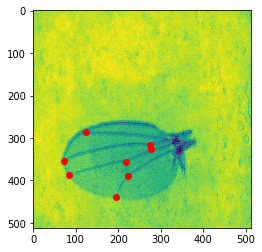

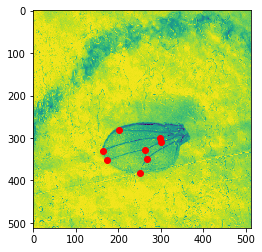

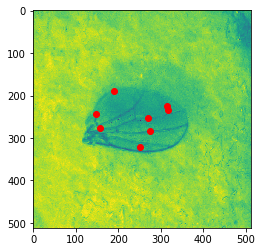

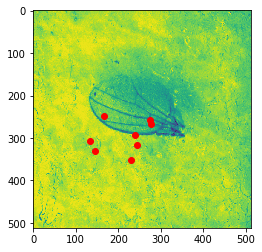

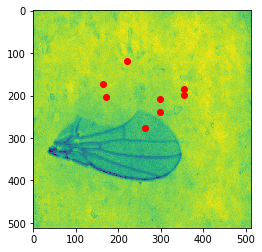

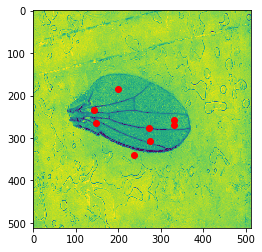

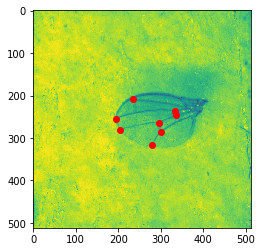

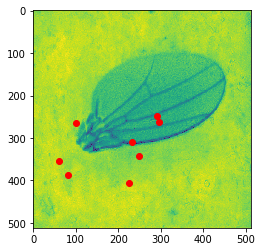

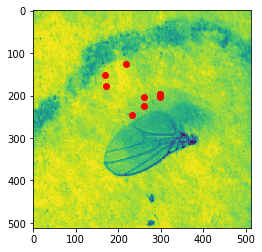

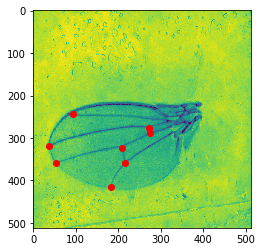

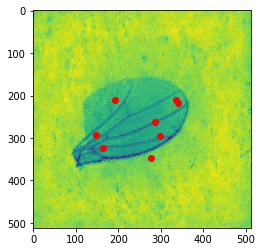

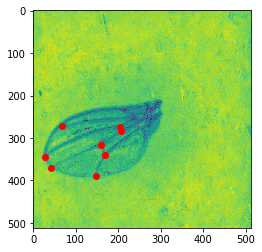

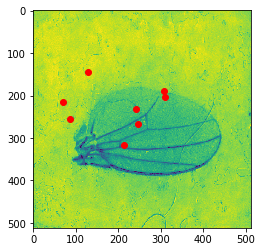

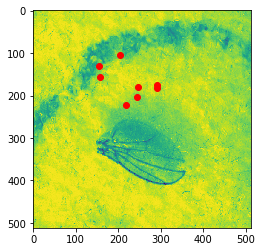

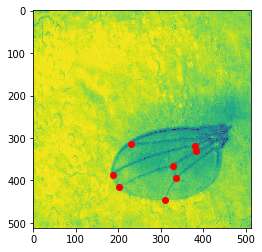

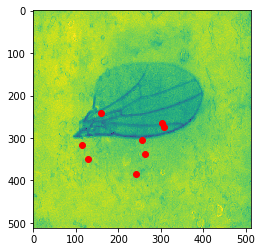

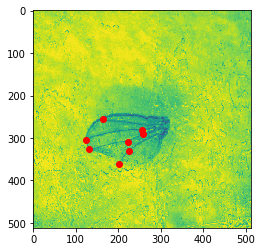

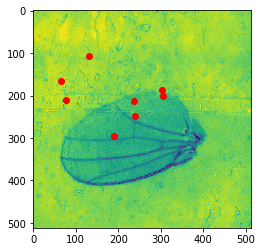

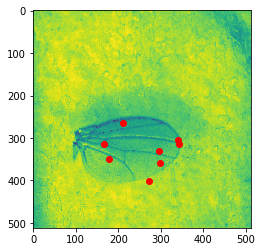

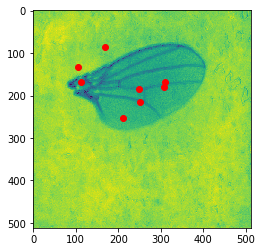

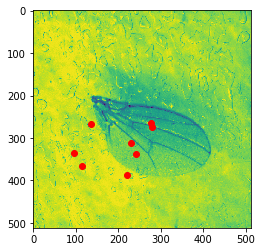

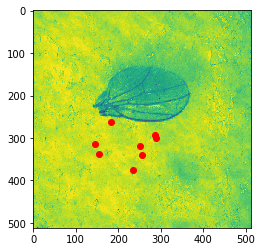

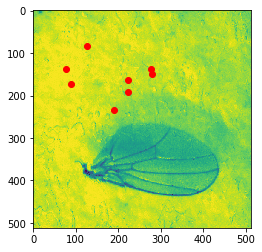

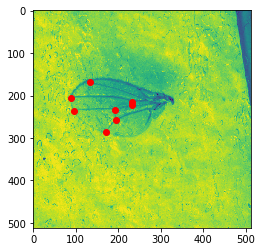

In [10]:
dataloader_test = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=False)

# dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
batch_iter = iter(dataloader_test)    
batch_test = batch_iter.__next__()

in_imgs = batch_test[0].numpy()
keypoints = batch_test[1].numpy()
path = batch_test[2]

# print("Shape data = {}, GT = {}".format(input_valid.shape, output_valid.shape))
for i in range(0, BATCH_SIZE, 1):
    img_in = in_imgs[i][0]
    print("======== {} ========".format(path[i]))
    print("Shape est={}, gt={}".format(img_in.shape, img_in.shape))
    plt.figure()
    plt.imshow(transforms.functional.to_pil_image(img_in))
    plt.scatter(keypoints[i][::2], keypoints[i][1::2], c='r')
#     plt.scatter(keypoints[i][4], keypoints[i][5], c='r')

In [6]:
output_linear = torch.nn.Linear(512, 16, bias=True)
model = models.resnet34(pretrained=True)

model.fc = output_linear
# model = nn.Sequential(
#     resnet34,
#     output_linear
# )

model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [7]:
# model = torch.load("/storage/data/models/wings")

In [8]:
criterion = nn.MSELoss()

optim = torch.optim.Adam(model.parameters())
#Loss tracking
loss_arr = []

In [ ]:
def roll_1(x, n):  
    return torch.cat((x[:, -n:], x[:, :-n]), dim=1)

def permutation_loss(kpts_gt, kpts_est):
    l_curr = criterion(kpts_gt, kpts_est)
#     print(l_curr)
#     print(kpts_est[0])
    for i in range(1, 9, 1):
        kpts_per = roll_1(kpts_est, 2*i)
        l_per = criterion(kpts_gt, kpts_per)
#         print(kpts_per[0])
#         print(l_per)
        if l_per < l_curr:
            l_curr = l_per
    return l_curr

In [ ]:
N_ITERS = 12
lr = 0.01;
if TRAIN:
    t = tqdm(range(N_ITERS), desc="epoch: ")
    for i in t:
        optim = torch.optim.Adam(model.parameters(), lr)
        rec = True
        inner = tqdm(dataloader, "batch: ", leave=False)
        for batch in inner:
            optim.zero_grad()
            images = batch[0].to(DEVICE, dtype=torch.float)
            labels = batch[1].to(DEVICE, dtype=torch.float)

            #Forward pass
            NN_out = model(images)
            loss = permutation_loss(NN_out, labels)

            #Training
            loss.backward()
            optim.step()

            loss_arr.append(loss.item())
            inner.set_description("loss: {:.5f}".format(loss.item()))

            #Set the first batch loss as the loss in the tqdm description
            if rec==True:
                t.set_description("loss: {:.5f}".format(loss.item()))
                rec = False
        lr = lr*0.5
        torch.save(model, "/storage/data/models/wings2")

In [ ]:
if TRAIN:
    plt.scatter(range(len(loss_arr[::1])), loss_arr[::1])

In [ ]:
dataloader_test = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

# dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
batch_iter = iter(dataloader_test)    
batch_test = batch_iter.__next__()

input_tensor = batch_test[0].to(DEVICE, dtype=torch.float)
gt_tensor = batch_test[1]

input_valid = (batch_test[1].cpu().detach().numpy())
output_valid = model(input_tensor).cpu().detach().numpy()
output_valid = np.squeeze(output_valid)

print("Shape data = {}, GT = {}".format(input_valid.shape, output_valid.shape))

In [ ]:
err = (abs(output_valid-input_valid)/input_valid)*100
print(np.mean(err))

In [ ]:
for i in range(0, BATCH_SIZE, 1):
    img_in = input_tensor[i][0].cpu().detach().numpy()
#     gt_pts = output_valid[i][0]
#     print("Shape est={}, gt={}".format(img_in.shape, img_in.shape))

#     f, axarr = plt.subplots(1,2)
    plt.figure()
    plt.imshow(transforms.functional.to_pil_image(img_in))
    plt.scatter(output_valid[i][::2], output_valid[i][1::2], c='r')
    plt.scatter(input_valid[i][::2], input_valid[i][1::2], c='b')
#     plt.scatter(input_valid[i][8], input_valid[i][9], c='b')
#     print(input_valid[i])
#     axarr[0].imshow(img_in, cmap='gray')